# CSE 5524 Computer Vision
## Homework Assignment #6
### Points: 16

## Steps to follow before starting on any homework

As a first step before starting on this homework, please save a copy of the provided HW6.ipynb by clicking on File -> Save Notebook As and then using the following file naming convention: lastname_OSUdotNumber_HW6.ipynb (for example: davis_1719_HW6.ipynb) for saving your Notebook file, which you will be working on and submitting for each homework.

Add your name and email by double clicking this cell and editing it.
### Name: Ethan Hessick
### OSU Email: hessick.4@osu.edu

After editing the cell you can run it by pressing the Shift key + Return key.


## Required Python Packages for Homework 6
1. Numpy (Installation documentation: [https://numpy.org/install/](https://numpy.org/install/))
2. MatPlotLib (Installation documentation: [https://matplotlib.org/stable/index.html#](https://matplotlib.org/stable/index.html#))
3. scikit-image (Installation documentation: [https://scikit-image.org/docs/stable/install.html](https://scikit-image.org/docs/stable/install.html))
4. SciPy (Installation documentation: [https://scikit-image.org/docs/stable/install.html](https://scikit-image.org/docs/stable/install.html))
5. math (Preinstalled Python package)
5. glob (Preinstalled Python package)

Note: Remember to restart your Notebook kernel by clicking on Kernel -> Restart Kernel... after installing any new packages in order to use the newly installed packages.

In [1]:
# Ensure you have already installed the required packages 
# and then run this cell (Shift+Return)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
from scipy import ndimage
import scipy
import skimage
import skimage.morphology as morph
import glob

## 1)	Covariance Tracking [6 pts]

###  Use the covariance matching technique to find the correct match in the color image provided (target.png) to the model covariance matrix (of <x,y,R,G,B> features) given below (notice x,y here maps to col,row!)

### i. Test all possible 1-pixel overlapping windows (each of size 50 rows by 60 columns, with the upperleft-corner as the window origin) in the image with the given model. Note that the given covariance matrix is biased (normalized with 1/(M*N)), and NumPy’s cov function is unbiased by default using 1/(M*N-1), so call np.cov() with the parameter bias=True to make it consistent (biased). 

### ii. Save the match distance for each box location in the image at each pixel location (for the origin of the window). 

### iii. Plot/display a bounding box of the best matching window over the original image and also generate the match-distance heatmap-image using the saved match distance for each box location's origin pixel (upperleft-corner). 

### iv. Report the (x,y) location of the best match distance for the best candidate. 

### Notes: Leave the image with colors ranging 0-255 (do not scale/normalize the colors). Make sure not to take a log() of zero at any time! 

In [2]:
# Model covariance matrix with the <x,y,R,G,B> features 
# (Note: x,y maps to col, row indices)
modelCovMatrix =\
np.array([[ 299.91666667, 0., 155.78016667, 91.14116667, 59.89516667],
[0., 208.25, -217.88783333, -190.02383333, -191.2815],
[155.78016667, -217.88783333, 3466.94698122, 3276.98432033, 3271.54424789],
[91.14116667, -190.02383333, 3276.98432033, 3271.56165767, 3296.09812033],
[59.89516667, -191.2815 , 3271.54424789, 3296.09812033, 3471.96084789]])

The origin for the bounding box with the smallest match distance (0.000) from the model is pixel [343, 140].


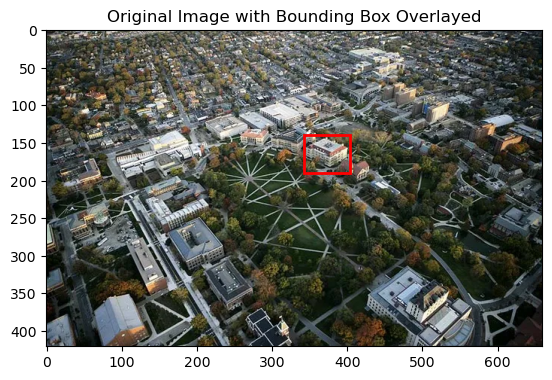

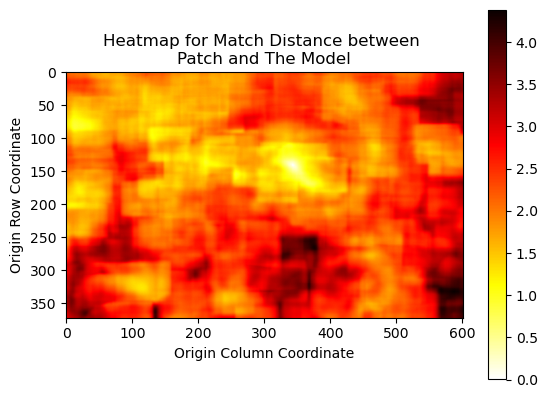

In [3]:
# Enter your code below
# load the image
targetImg = skimage.io.imread('target.png')

maxRow = targetImg.shape[0] # get size of image
maxCol = targetImg.shape[1]

# create matrix of x, y, RGBs
rasterizedTargetImg = np.zeros([maxCol*maxRow, 5])
for row in range(0, maxRow):
    for col in range(0, maxCol): # for each pixel in the array
        index = row*maxCol + col
        rasterizedTargetImg[index] = [col, row, targetImg[row][col][0], targetImg[row][col][1], targetImg[row][col][2]]

# print(rasterizedTargetImg)

# create array to store distances
matchDists = np.zeros([maxRow-49, maxCol-59]) 

# i - Test all possible 1 pixel overlapping windows
for row in range(0, maxRow-49):
    for col in range(0, maxCol-59): # for each pixel in the array

        # ensure pixels will be inbounds
        maxBoxRow = row+50
        maxBoxCol = col+60
        indicies = [r*maxCol + c for r in range(row, maxBoxRow) for c in range(col, maxBoxCol)]
        thisMatrix = rasterizedTargetImg[indicies] # Get subsection of rasterized image for the window
        # print(thisMatrix)

        # ii - Save match distance for each pixel location
        # calculate covariance matrix
        thisCov = np.cov(thisMatrix.T, bias=True)
        # print(thisCov.shape)

        # find generalized eigenvalues
        theseEigs = scipy.linalg.eigvals(modelCovMatrix, thisCov)
        theseEigs = np.real(theseEigs)
        # print(theseEigs)

        # find distance
        nonzero = 1e-10
        thisDist = np.sqrt(np.sum(np.log(theseEigs + nonzero)**2))
        matchDists[row,col] = thisDist

# print(thisMatrix)
# print(matchDists)

# iv - Report the origin for the smallest distance
origin = np.argmin(matchDists) # use argmin to get minimum index
origin_colRow = [np.floor(origin / matchDists.shape[1]).astype('int'), origin%matchDists.shape[1]] # have to convert to 2d coordinates - wish built in function did this! 
origin_xy = [origin_colRow[1], origin_colRow[0]] # have to flip since [x,y] is opposite order as [row,col]
print(f'The origin for the bounding box with the smallest match distance ({matchDists[origin_colRow[0],origin_colRow[1]]:0.3f}) from the model is pixel {origin_xy}.') # print to screen
# print(np.min(matchDists), '=', matchDists[origin_coords[0],origin_coords[1]], '?') # testing

# iii - Show a bounding box over the best match window over the original image
fig, ax = plt.subplots()
ax.imshow(targetImg) # print image
bounding_box = patches.Rectangle(origin_xy, 60, 50, linewidth=2, facecolor='none', edgecolor='r') # make bounding box patch
ax.add_patch(bounding_box) # print bounding box
ax.set_title('Original Image with Bounding Box Overlayed')
plt.show()

# iii - Generate a heatmap-image for each pixel using its distance from the given covMatrix
plt.imshow(matchDists, cmap='hot_r') # print heat map
plt.title('Heatmap for Match Distance between \nPatch and The Model')
plt.ylabel('Origin Row Coordinate')
plt.xlabel('Origin Column Coordinate')
plt.colorbar()

plt.show()



### Discussion
The covariance tracking algorithm selected a building on campus (I believe Mendenhall Hall).
The heatmap shows that there are a few other areas where the match distance has local minima. I used a reverse heat map, so the bright regions show lower patch distances (closer to the model, more likely to be the match). There are a similar regions on this image with buildings that have similar orientations, so it makes sense that other areas in the image would also have local mins for the patch distance. I think it would be interesting to test for other patches in this image (like other buildings, or areas of the oval) to see how well the model is able to recognize other specific regions well. 

## Mean-Shift:

## 2)	Create a function to extract a feature vector for each pixel in a circular neighborhood (< radius) around a given (x,y) location for a given image. For each pixel, use the same format to return as used above (<xi,yi,R,G,B>). That is, X should be a Kx5 matrix, where each row is for one of the pixels in the neighborhood. Assume that the (x,y) passed into the function are real (non-integer) values, and do NOT round them in the function for computation of the neighborhood. [2 pts]

In [4]:
# Define a function to extract a feature vector for 
# each pixel in a circular neighborhood
# Inputs: img: Input image, x,y: real valued pixel locations,
# radius: radius of circular neighborhood
# Output: Kx5 matrix, where each row is the (<xi,yi,R,G,B>) 
# feature for one of the pixels in the neighborhood.

def circularNeighbors(img, x, y, radius):
    # Enter code below

    X = list()
    
    for row in range(0,img.shape[0]): # cycle through each pixel
            for col in range(0,img.shape[1]):
                # compute the distance from x,y
                distance = np.sqrt((row-y)**2 + (col-x)**2)

                # if the distance is within the radius, add the pixel to the list of circular neighbors
                # Dont need to center x and y coordinates here because its done in the helper colorHistogram function
                if distance < radius:
                     X.append([col, row, img[row][col][0], img[row][col][1], img[row][col][2]])
                     # print(img[row][col])

                else:
                    continue    
    
    X = np.array(X) # convert from list to array
    
    return np.array(X)

## Use the following helper function provided that builds a color histogram from a neighborhood of points. The histogram (hist) returned is a bins x bins x bins color cube (RxGxB). The bins are evenly spaced. For example, if bins=4 then the pixel-value limits for each bin will be {0-63, 64-127, 128-191, 192-255}. The histogram is weighted using an Epanechnikov kernel centered at real-valued (x, y) and with bandwidth h. The returned histogram/cube is normalized and sums to 1. (This function will be used to make your model histogram “q_model” and to make the candidate test histogram “p_test”)

In [5]:
# Function to build a color histogram from a 
# neighborhood of points
def colorHistogram(X, bins, x, y, h):
    # Create empty histogram cube of size
    # bins x bins x bins
    hist = np.zeros((bins, bins, bins))
    # Calculate the size of each bin
    bin_size = math.floor(256/bins)
    for i in X:
        x0=i[0]
        y0=i[1]
        R_bin = int(np.floor(i[2]/bin_size))
        G_bin = int(np.floor(i[3]/bin_size))
        B_bin = int(np.floor(i[4]/bin_size))
        weight = (((math.sqrt(((x-x0)**2)+((y-y0)**2)))/h)**2)
        if(weight<1):
            weight = 1-weight
        else:
            weight = 0
        # print(i[2], R_bin)
        hist[R_bin,G_bin,B_bin] = hist[R_bin,G_bin,B_bin]\
                                                + weight

    hist = hist/ np.sum(hist)
    return hist

## 3)	Create a function to calculate a vector of the mean-shift weights (w), where there is a weight w_i for each pixel i in the neighborhood: [3 pts]

In [6]:
# Define a function to calculate a vector of 
# the mean-shift weights 
# Inputs: 
# X: Input model features, 
# q_model: Model histogram, 
# p_test: Candidate test histogram, 
# bins: Number of bins
# Output: w: Vector of mean-shift weights

def meanshiftWeights(X, q_model, p_test, bins):
    # Enter code below 
    bin_size = math.floor(256/bins)

    # store values
    w = np.zeros(X.shape[0])

    # cycle through pixels in X
    for i in range(0,X.shape[0]):

        pixel = X[i] # find this pixel
        # find this pixels bins
        R_bin = int(np.floor(pixel[2]/bin_size))
        G_bin = int(np.floor(pixel[3]/bin_size))
        B_bin = int(np.floor(pixel[4]/bin_size))

        # add sqrt(q / p) to this pixels weight
        nonzero = 1e-10
        w[i] = np.sqrt(q_model[R_bin][G_bin][B_bin] / (p_test[R_bin][G_bin][B_bin]))
            
    return w

### 4) Load the given images img1.jpg and img2.jpg, and use the functions above to perform mean-shift tracking. Build a model from img1 using a circular neighborhood with a radius of 40 pixels centered at (x0,y0) = (290.0, 195.0) and a color histogram of size 16x16x16 (cube). Use the provided helper function to build the weighted cube histogram using an Epanechnikov kernel with bandwidth h = 25. Run 25 iterations of mean-shift tracking on img2. DO NOT ROUND coordinates or values at any time! Report the final (x, y) location (DO NOT ROUND) and Euclidean distance between the last two iterations (see Step 4 on the Algorithm slide). [4 pts]

In [7]:
# Enter code below 

# Load the given images
img1 = skimage.io.imread('img1.jpg')
img2 = skimage.io.imread('img2.jpg')
# print(np.max(img1))

# Build model from img1 using a radius=40 pixel radius, centered at (290.0,195.0)
x0 = 290.0 # initialize parameters
y0 = 195.0
h = 40
bins = 16
qNeighbors = circularNeighbors(img1, x0, y0, h) # custom functions to get to matrix of neighbor pixels and RGB values then color histogram
# print(np.max(qNeighbors[:,2:5]))
qModel = colorHistogram(qNeighbors, bins, x0, y0, h)

# initial parameters for first round of img 2 model
x = x0
y = y0

# iterate 25 times
for iterations in range(0,25):
    # make model for img2
    pNeighbors = circularNeighbors(img2, x, y, h)
    pTest = colorHistogram(pNeighbors, bins, x, y, h)  

    # find weights for this iterations
    # print(pNeighbors)
    weights = meanshiftWeights(pNeighbors, qModel, pTest, bins)
    #print(weights.shape)
    #print(weights)

    # update x,y using the weights
    weighted_xs = [pNeighbors[i][0] * weights[i] for i in range(0,weights.shape[0])]
    xNext = np.sum(weighted_xs) / np.sum(weights)

    weighted_ys = [pNeighbors[i][1] * weights[i] for i in range(0,weights.shape[0])]
    yNext = np.sum(weighted_ys) / np.sum(weights)

    distance = np.sqrt((x-xNext)**2 + (y-yNext)**2)
    x = xNext
    y = yNext

    print(f'Iteration #{iterations+1} (x,y) = ({x:0.4f} , {y:0.4f})')

print(f'\nThe final coordinates are ({x:0.4f} , {y:0.4f}).\n\
The Euclidean Distance between the coordinates for the last mean shift iteration is {distance:0.4f} pixels.')




Iteration #1 (x,y) = (290.3770 , 195.9639)
Iteration #2 (x,y) = (290.8085 , 196.5739)
Iteration #3 (x,y) = (291.2885 , 197.0064)
Iteration #4 (x,y) = (291.8453 , 197.4023)
Iteration #5 (x,y) = (292.3604 , 197.7214)
Iteration #6 (x,y) = (292.9381 , 197.9318)
Iteration #7 (x,y) = (293.4967 , 198.1862)
Iteration #8 (x,y) = (294.1408 , 198.5714)
Iteration #9 (x,y) = (294.8539 , 198.8466)
Iteration #10 (x,y) = (295.4616 , 199.1198)
Iteration #11 (x,y) = (296.0918 , 199.5790)
Iteration #12 (x,y) = (296.7875 , 199.9318)
Iteration #13 (x,y) = (297.4036 , 200.3035)
Iteration #14 (x,y) = (298.0174 , 200.7693)
Iteration #15 (x,y) = (298.5971 , 201.1271)
Iteration #16 (x,y) = (299.1380 , 201.6184)
Iteration #17 (x,y) = (299.6486 , 201.9824)
Iteration #18 (x,y) = (300.1570 , 202.3357)
Iteration #19 (x,y) = (300.6085 , 202.7327)
Iteration #20 (x,y) = (301.0078 , 203.0331)
Iteration #21 (x,y) = (301.3622 , 203.3627)
Iteration #22 (x,y) = (301.7183 , 203.6924)
Iteration #23 (x,y) = (301.9580 , 203.899

### 5) Display the two images with a circular boundary of radius 40 centered on the initial (x0, y0) position on img1 and the final (x,y) position on img2 resulting from 25 mean-shift iterations. Discuss the results. [1 pt]

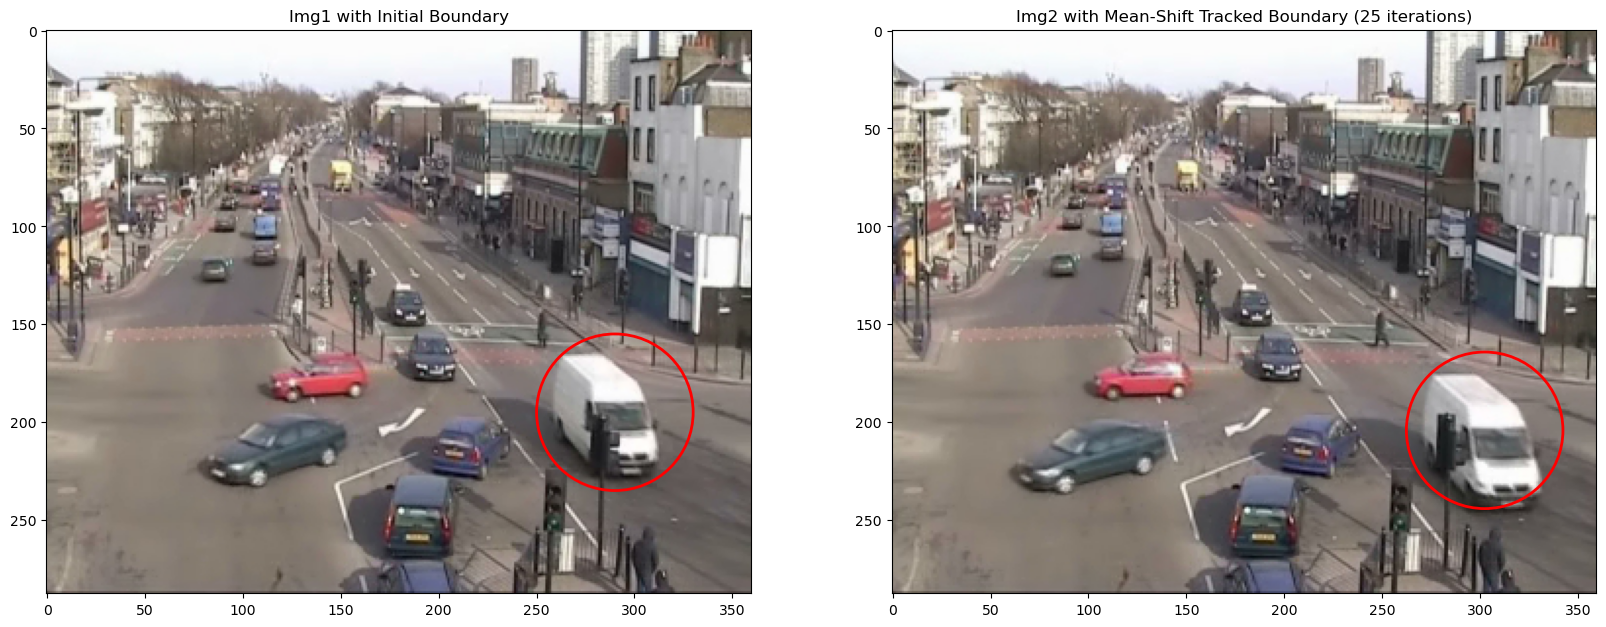

In [8]:
# Display the results by plotting the initial and
# final circular neighborhoods 

# make subplots
fix, ax = plt.subplots(1,2,figsize=(20,20))

# plot first image
ax[0].imshow(img1)
initial_boundary = patches.Circle([x0,y0], radius=h, linewidth=2, facecolor='none', edgecolor='r')
ax[0].add_patch(initial_boundary) # print initial boundary
ax[0].set_title('Img1 with Initial Boundary')
ax[0].axis('image')

# plot second image
ax[1].imshow(img2)
final_boundary = patches.Circle([x,y], radius=h, linewidth=2, facecolor='none', edgecolor='r')
ax[1].add_patch(final_boundary) # print mean shifted boundary
ax[1].set_title('Img2 with Mean-Shift Tracked Boundary (25 iterations)')
ax[1].axis('image')

plt.show()



### Discussion
The target is a white van. This can be seen in image 1 (left above). The model successfully tracks the white van as it drives down the road for image 2 (right). One advantage of using color histograms is that the van's orientation changing and the movement of the van relative to obstacles (like the stoplight), do not change the van's color histogram as much as it would affect its covariance matrix. It helps that in this image sequence, the van has not moved too far. 
I think a couple improvements for this specific code could be to use an ellipse (to better track the van shape), to check higher image pyramid layers (since the van gets larger as it gets closer), and to use thresholding to decide when to stop the mean shift algorithm's iterations instead of relying on a set number of iterations. 
I have an older computer (~2017 Macbook) that is sorta slow for these kind of applications. I was impressed by how much quicker this algorithm executed than the covariance algorithm in problem 1. 

## Final Submission 
1. Ensure you save the Notebook after adding all your code and discussion of results.
2. Verify that your completed Submission Notebook file follows the file naming convention lastname_OSUdotNumber_HW6.ipynb (for example: davis_1719_HW6.ipynb)
2. Make a lastname_OSUdotNumber_HW6.zip (for example: davis_1719_HW6.zip) file containing your submission notebook file along with the input data required for the homework.
3. Upload your zip file to Carmen (Only zip file submissions will be accepted on Carmen).

Make sure to upload your submission BEFORE the deadline and verify that it was indeed accepted by Carmen!